# Análisis Exploratorio de los Datos

Como se menciona en la introducción, los datos son tomados de la *Home Mortgage Disclosure Act*, que permite filtrar los datos según varios sectores de la población. En primer lugar, se filtraron aquellas observaciones donde el resultado del prestamo dependiera completamente del ente que concede el préstamo, dado que lo que se quiere predecir es si la entidad acepta el préstamo o no.

## Contenido

1. [Glosario](#Glosario)
2. [Datos faltantes](#Datos-faltantes)
3. [Variable Respuesta](#Variable-Respuesta)
4. [Análisis bivariado](#Análisis-bivariado)

## Glosario

Las variables más relevantes de la base de datos, y sus posibles valores en caso de ser categórica:

- `action_taken`: El resultado de la petición, esta es la variable que se buscará predecir. 
    - 1: Aprovado
    - 0: Desaprovado

- `derived_race`: Raza obtenida según la base de datos original. Contiene la misma información pero se encuentra desempaquetada de modo que no presente una inflación para la base de datos. 
    - American Indian or Alaska Native
    - Asian
    - Black or African American
    - Native Hawaiian or Other Pacific Islander
    - White
    - 2 or more minority races
    - Joint
    - Free Form Text Only
    - Race Not Available

- `derived_ethnicity`: Etnicidad obtenida similarmente a la raza:
    - Hispanic or Latino
    - Not Hispanic or Latino
    - Joint
    - Ethnicity Not Available
    - Free Form Text Only

- `applicant_sex`: Sexo del aplicante para el préstamo:
    - 1: Male
    - 2: Female
    - 3: Information not provided by applicant in mail, internet, or telephone application
    - 4: Not applicable
    - 6: Applicant selected both male and female

- `applicant_age`: Intervalo de edad del aplicante:
    - < 25
    - 25-34
    - 35-44
    - 45-54
    - 55-64
    - 65-74
    - \> 74

- `income`: Ingresos anuales del aplicante en miles de dólares. 

- `loan_amount`: Cantidad total del préstamo en dólares.

- `loan_term`: Número de meses para culminar el préstamo

- `conforming_loan_limit`: Indica si el préstamo excede el límite impuesto por la *GSE*:
    - C: Conforming
    - NC: Nonconforming
    - U: Undetermined
    - NA: Not Applicable

- `property_value`: El valor de la propiedad usado para asegurar el préstamo.

- `lien_status`: Indica si el acreedor tendrá prioridad en recibir el pago o se encuentra en una cola:
    - First lien: El acreedor tiene la prioridad sobre recibir el pago.
    - Subordinate lien: El acreedor se encuentra en fila para recibir el pago.

- `tract_population`: Población en el sector.
- `ffiec_msa_md_median_family_income`: Mediana de los ingresos familiares en el sector.
- `tract_owner_occupied_units`: Número de unidades ocupadas por su respectivo dueño en el sector.
- `tract_one_to_four_family_homes`: Número de moradas construidas con menos de 5 familias.
- `tract_median_age_of_housing_units`: Mediana de las edades en el sector.


## Datos faltantes

Los datos faltantes se pueden observar en el siguiente gráfico:

In [1]:
import plotly.graph_objs as go
import plotly.express as px
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

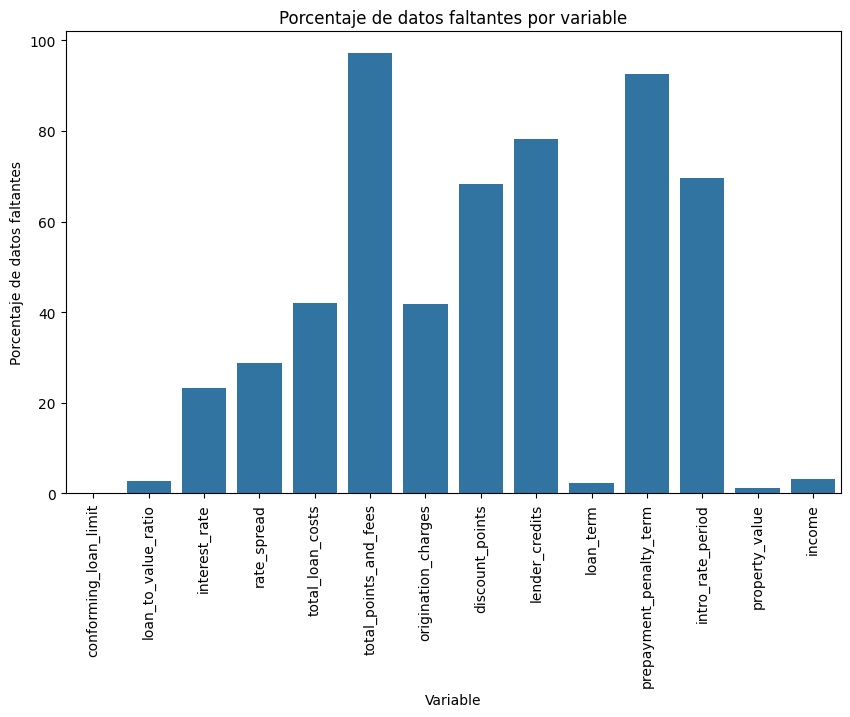

In [2]:
data = read_csv('hmda_mapped.csv', dtype={'total_units':str} )
missing = (data.isnull().sum() / len(data)) * 100
missing = missing[missing > 0]

missing = (data.isnull().sum() / len(data)) * 100
missing = missing[missing > 0]

plt.figure(figsize=(10, 6))
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Porcentaje de datos faltantes')
plt.title('Porcentaje de datos faltantes por variable')
plt.show()

Como se ve en la gráfica, hay variables con un porcentaje de datos faltantes de más del 20%, por lo que es razonable eliminar estas del conjunto, ya que no se puede extraer mucha información de estas, por otro lado, aquellas con un porcentaje menor al 20% se llenarán con un imputado por la media de la columna. Este proceso se evidenciará mejor en el capítulo de preprocesamiento.

## Variable respuesta

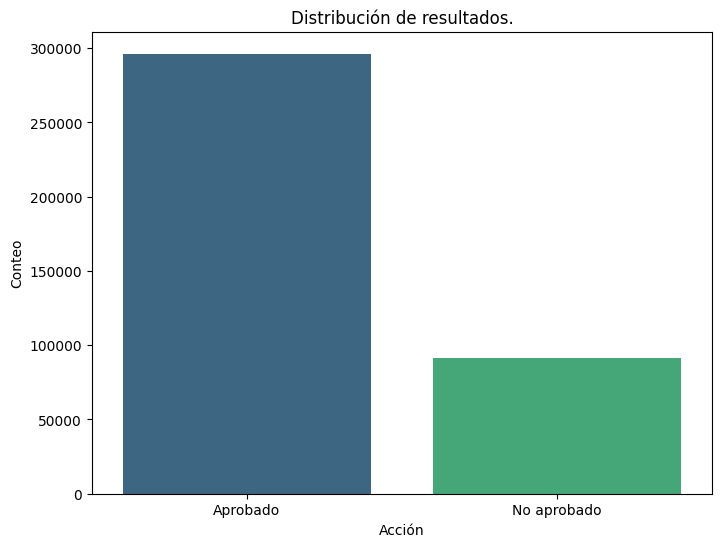

In [3]:
# Response
action_taken = data['action_taken'].value_counts()
action_labels = {0: 'No aprobado', 1: 'Aprobado'}
action_taken.index = action_taken.index.map(action_labels)

# Failsafe
data['status'] = data['action_taken'].map(action_labels)

plt.figure(figsize=(8, 6))
sns.barplot(x=action_taken.index, y=action_taken.values, palette='viridis', hue=action_taken.index)
plt.xlabel('Acción')
plt.ylabel('Conteo')
plt.title('Distribución de resultados.')
plt.show()

Podemos observar que hay un desbalance marcado entre las categorías de la variable respuesta, y dada la cantidad de observaciones, se usarán métodos de *undersampling* donde se reduzcan las muestras irrelevantes para el modelo.

## Análisis bivariado

In [4]:
def plot_categorical( col ):
    
    clean = data.dropna(subset=[col])
    grouped_data = clean.groupby(['status', col]).size().unstack(fill_value=0).dropna()
    total_per_category = grouped_data.sum(axis=1)
    proportion_data = grouped_data.div(total_per_category, axis=0)

    colormap = plt.get_cmap('viridis')
    colors = colormap(np.linspace(0, 1, proportion_data.shape[1]))

    proportion_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    
    plt.xlabel('Resultado')
    plt.ylabel('Proporción')
    plt.title(f'Proporción de {col} según resultado')
    plt.legend(title=col, bbox_to_anchor=(1.05, 1))
    plt.show()

def plot_numerical( col ):
    clean = data.dropna(subset=[col])
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=clean, y='status', x=col, hue='status')
    plt.xlabel(col)
    plt.ylabel('Resultado')
    plt.title('Boxplot de resultado según ' + col)
    plt.show()

### Aceptación del préstamo según información personal.

A continuación podemos ver la relación entre la variable respuesta y variables relacionadas a la información personal del aplicante.

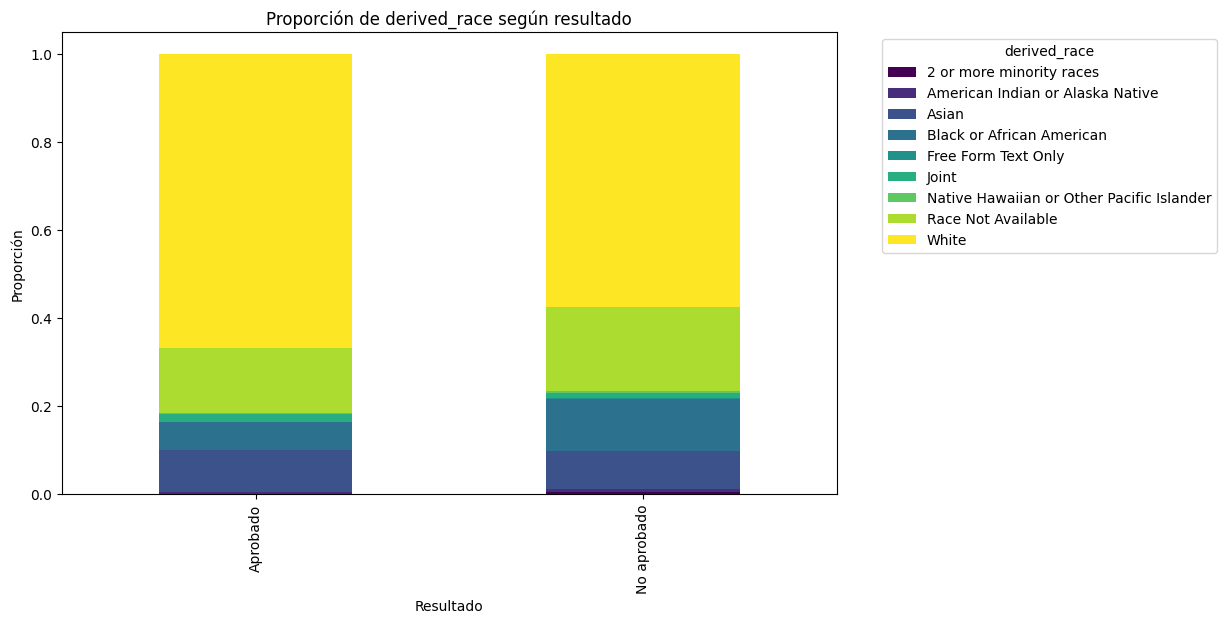

In [5]:
plot_categorical( 'derived_race' )

Como se podría esperar, la proporción dominante en ambos resultados del préstamo son los denominados blancos, a pesar que hay una mayoría de estos en los créditos aprovados, aún así superan en 50% de la población. Por otro lado, podemos ver como la proporción de negros o afroamericanos supera por el doble en la categoría de desaprobados, por lo que queda como pregunta de investigación determinar si el racismo entra a colación a la hora de la aprobación de créditos o hay otros factores para la población que influyan en este resultado.

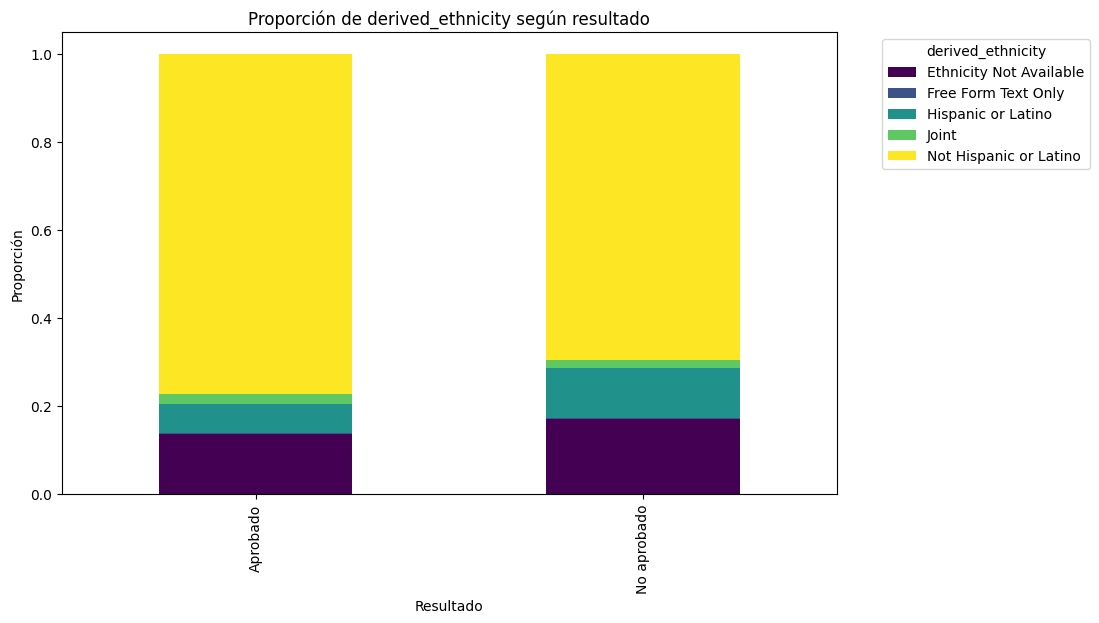

In [6]:
plot_categorical( 'derived_ethnicity' )

De la misma forma que la variable anterior, la proporción dominante se encuentra en "No hispano", donde se esperaría que la mayor cantidad de gente blanca esté. En ambos resultados superan los 2/3 del total, mientras que se encuentra una mayor proporción en los aprovados. Por otro lado, los autodenominados hispanos comparten una desproporción similar a la que se vió con los afroamericanos en la raza, donde la proporción es aproximadamente el doble que de los aprobados.

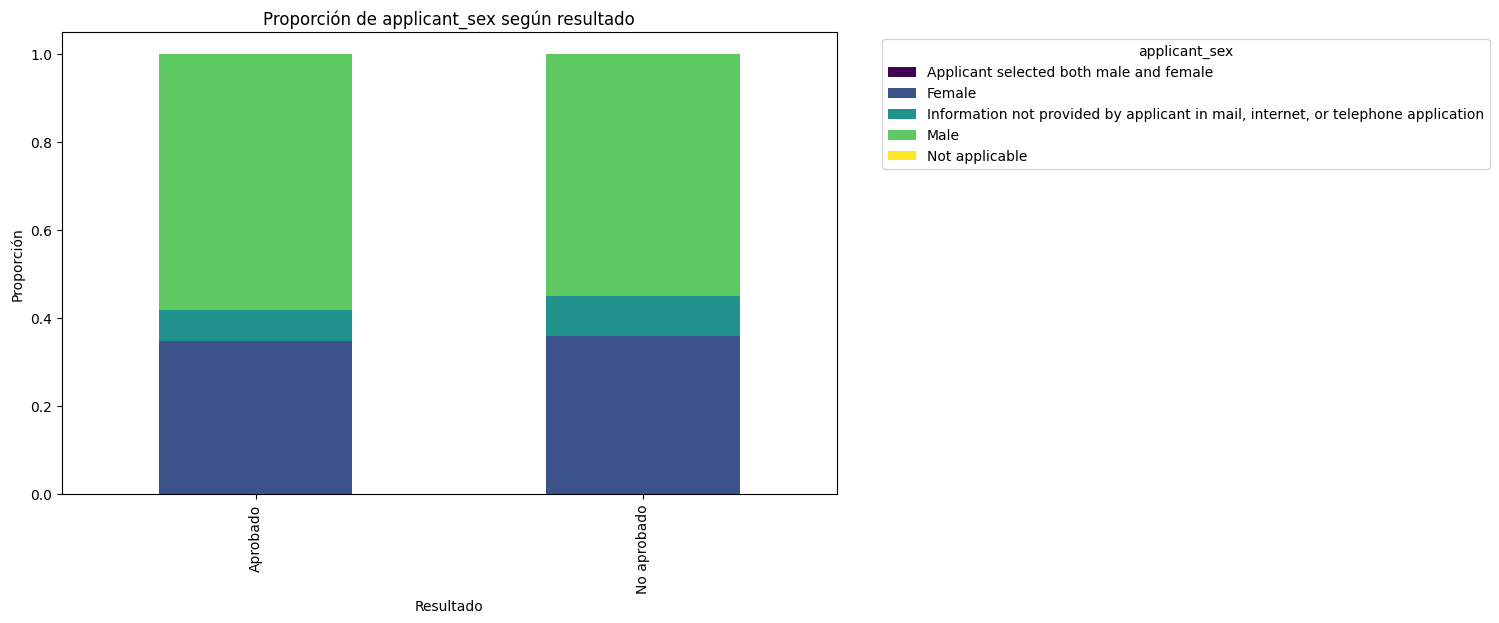

In [7]:
plot_categorical( 'applicant_sex' )

Podemos ver que ambos sexos mantienen una proporción muy cercana entre ambos resultados, a pesar que haya una mayor proporción de hombres que de mujeres en general. De todos modos se puede observar una ligera tendencia entre ambos sexos, ya que la proporción de hombres aprovados es ligeramente mayor que de aquellos desaprovados. De forma inversa, las mujeres desaprobadas presentan una ligera mayoría con respecto a las aprovadas. Estas diferencias tan sutiles podrían surgir dado el desbalance entre las clases.

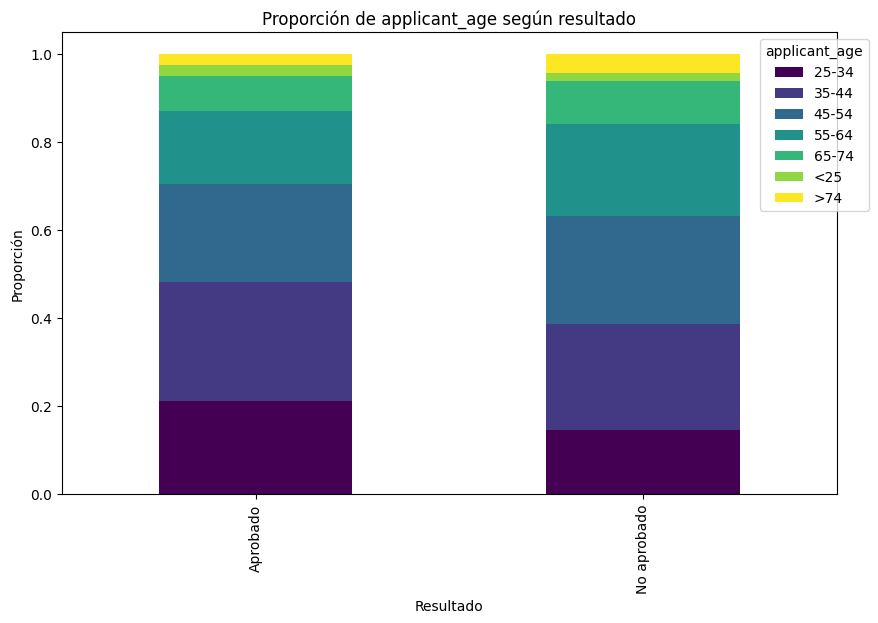

In [8]:
plot_categorical( 'applicant_age' )

De manera similar a la variable anterior, todas las edades se distribuyen de forma similar para ambos resultados, habiendo una mayoría en los intérvalos entre 35-44 y 45-54. La diferencia notable entre los resultados del intervalo 55-64 se pueden deber dada la inclusión de un sector de la población entre 62 a 64 años, ya que aquellos adultos mayores de 62 años en adelante pueden recibir un tipo especial de préstamo llamado reverse mortgage, variable que se tiene en cuenta en el estudio.

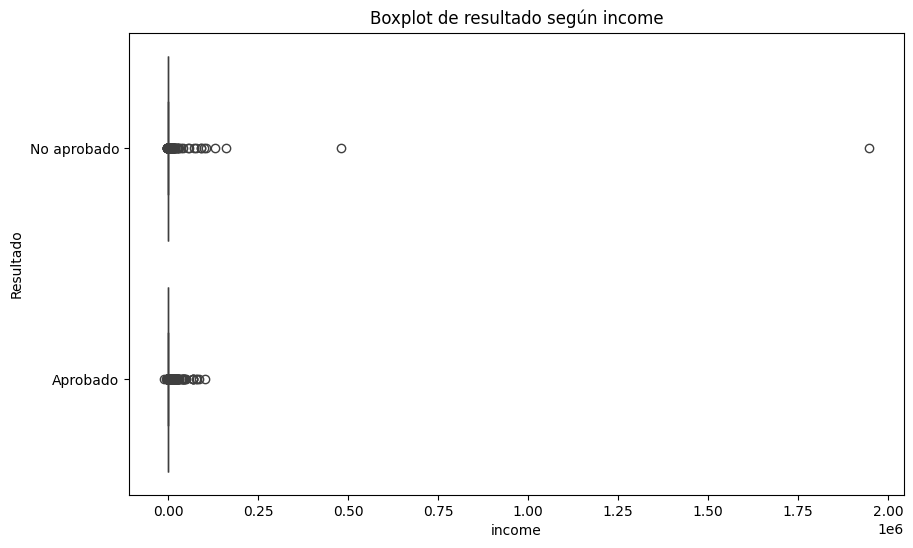

In [9]:
plot_numerical( 'income' )

Podemos ver que a nivel general, la mediana de los aprovados supera en 29k dólares anuales a aquellos que no fueron aprobados. Por otro lado, podemos encontrar valores extremadamenteo atípicos, tales como ingresos negativos en los millones, así como un ingreso de aproximadamente 2 mil millones de dólares, lo que puede ser muy probablemente un dato atípico. Podemos ver entonces que existe cierta diferencia entre ambas variables según su salario anual.

### Aceptación del préstamo según datos del préstamo

A continuación podemos ver la relación entre la aceptación del prestamo y los datos del este tales como el valor, periodo, entre otros.

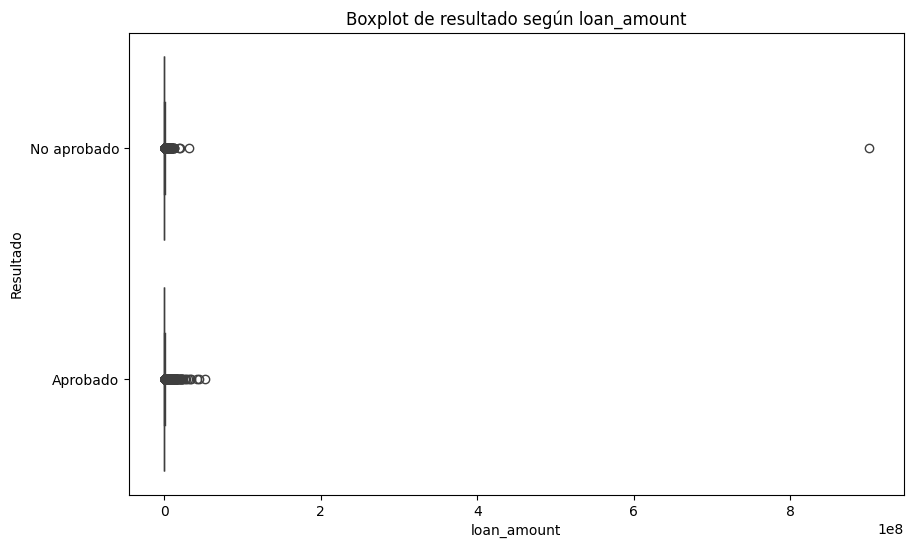

In [10]:
plot_numerical('loan_amount')

Al contrario de lo que se esperaría, la mediana de los aprobados es superior a la de los desaprobados por cerca de 80k dolares en total, lo que nos puede indicar que hay una tendencia a que las deudas más grandes son más propensas a ser aprobadas si se observan los datos por separado. Podemos notar un dato extremadamente atípico de 900 millones desaprobado, caso que se puede dar ya sea por un error de registro de datos, o puede ser el mismo dato atípico visto previamente en el salario anual.

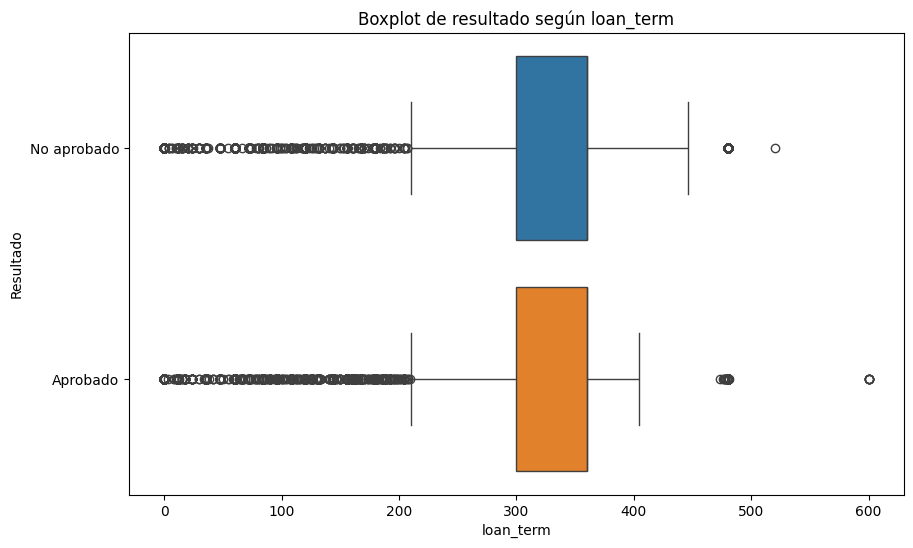

In [11]:
plot_numerical( 'loan_term' )

Es de esperarse que ambas medianas se concentren en los 20 años ya que es un plazo esperado para el pago de una deuda tan grande, de la misma forma ambos resultados distribuyen sus meses de forma similar, estando la mayoría de datos entre los 15 y 35 años.

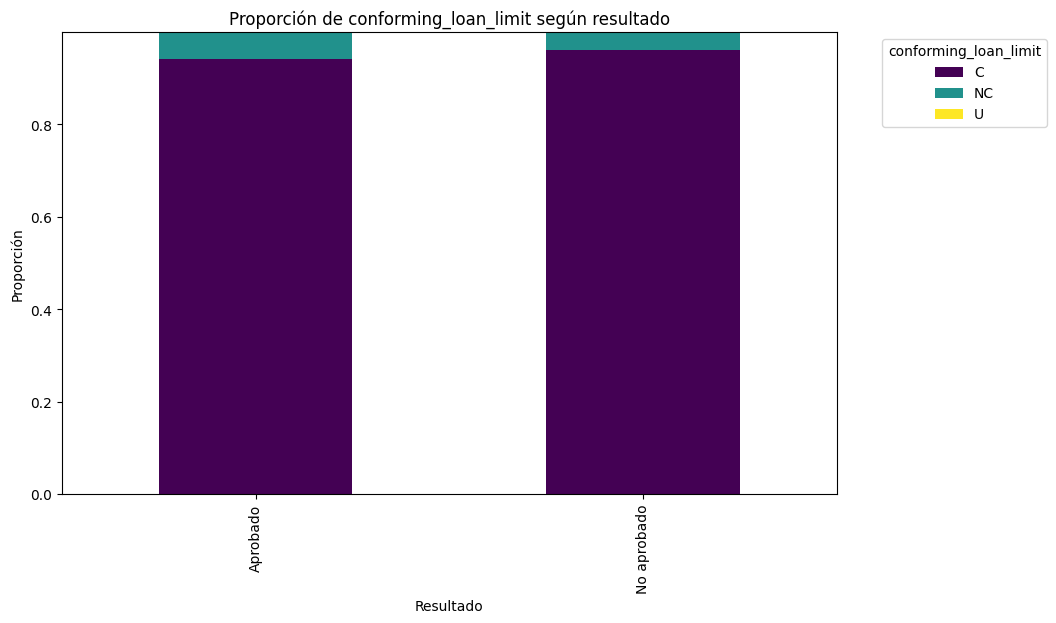

In [12]:
plot_categorical('conforming_loan_limit')

Es notorio que la gran mayoría de préstamos se encuentran por debajo del umbral establecido por la GSE, donde mas del 90% cumplen con el requerimiento. Es sorprendente aún así, que entre los que no cumplen con la restricción, los aprobados superen en un 50% la proporción de los no aprobados.

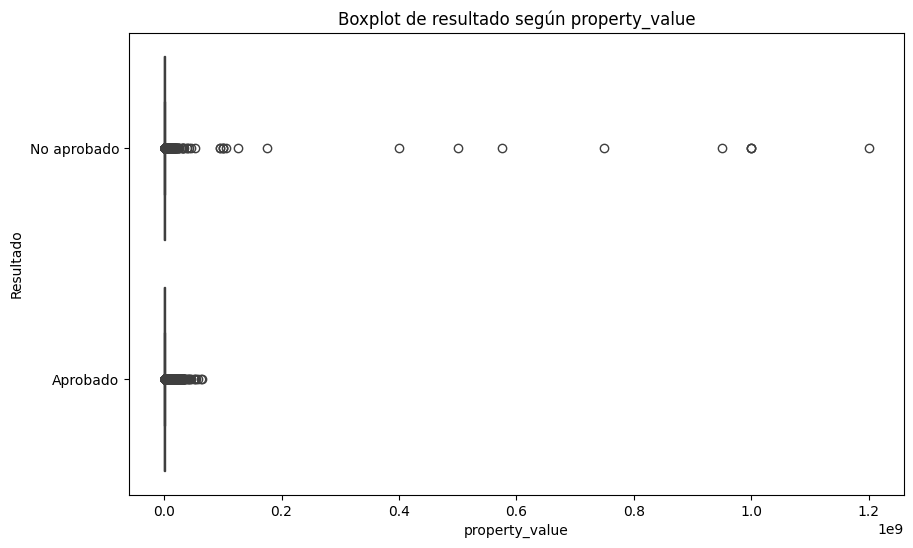

In [13]:
plot_numerical('property_value')

En este gráfico, podemos observar como la diferencia entre las medianas no es tan grande según el resultado, siendo la mediana de los desaprobados ligeramente superior. Tambien cabe resaltar que en general, los desaprobados tienen datos atípicos más grandes, y nuevamente es posible observar un valor extremadamente alto que puede ser la misma observación antes vista, o, nuevamente, un error a la hora de registrar los datos.

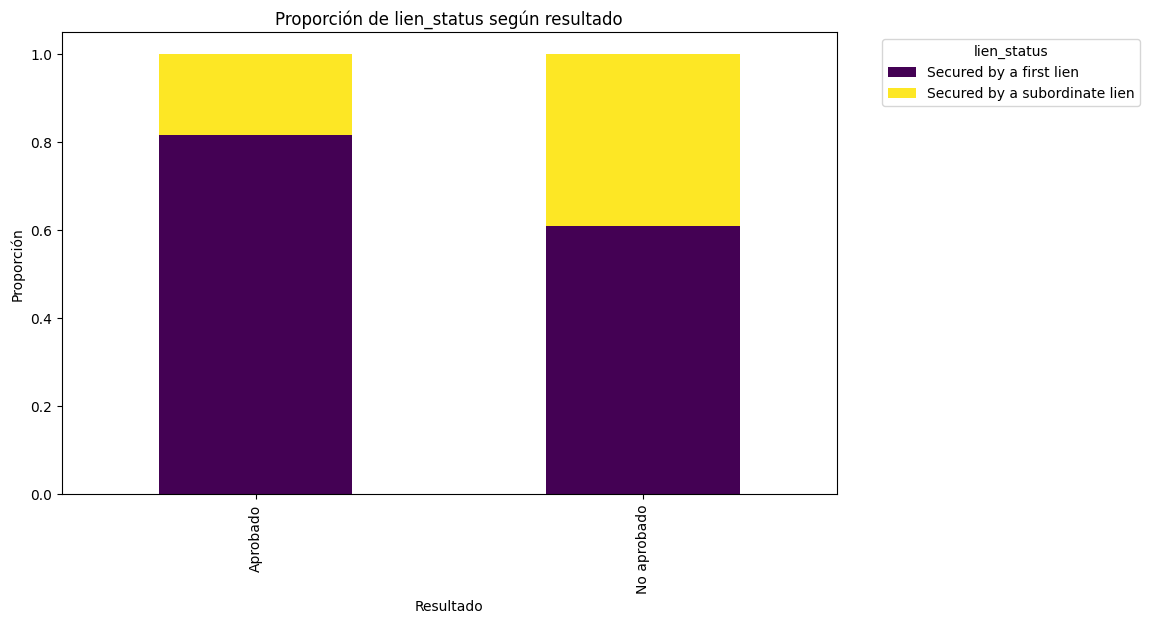

In [14]:
plot_categorical('lien_status')

Dado que un lien subordinado implica quedar en segundo lugar para el retorno del préstamo, es evidente que una mayor proporción de estos se encontrarán en los desaprobados, donde aproximadamente el doble de liens subordinados están sobre los subordinados de un resultado aprobado.

### Aceptación del préstamo según datos del sector

La HMDA tiene cuenta varias variables pretenecientes al sector, denomidado como *tract*. A continuación podemos ver la relación entre estas variables y la acción tomada.

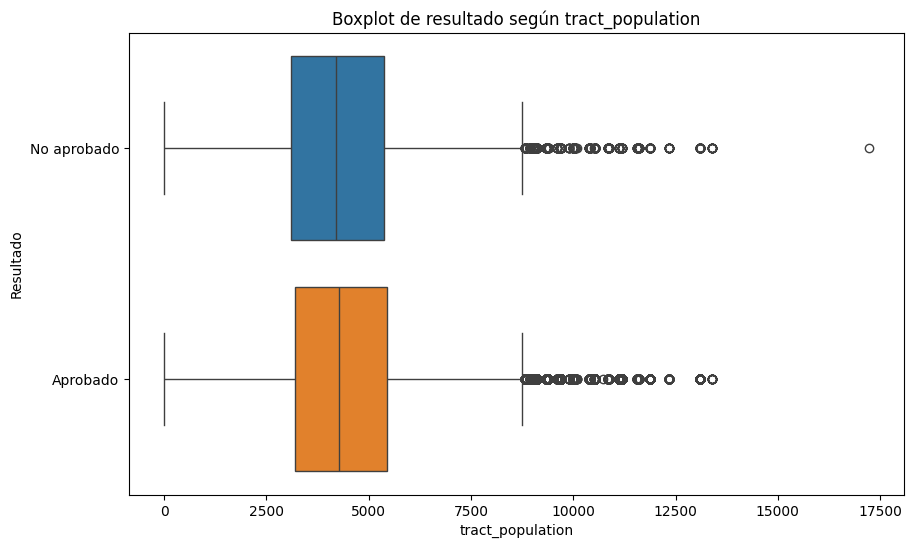

In [15]:
plot_numerical('tract_population')

A diferencia de muchas variables previas, podemos observar como ambos resultados mantienen distribuciones de los datos idénticas, siendo la única diferencia un dato atípico muy alto en los no aprobados, y una mediana ligeramente superior por parte de los aprobados.

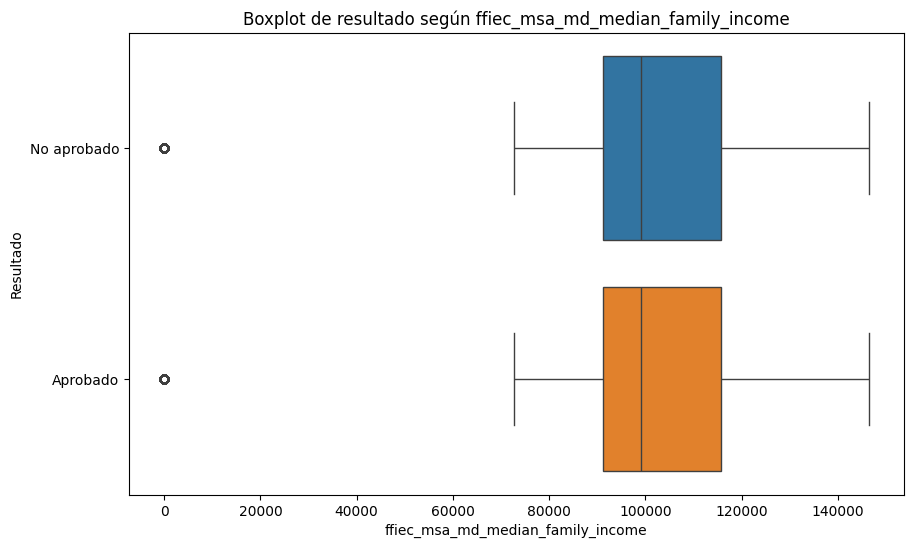

In [16]:
plot_numerical('ffiec_msa_md_median_family_income')

De manera similar, a la variable anterior, ambos resultados comparten una distribución idéntica, manteniendo la misma mediana e incluso un dato atípico, que puede ser resultado de un mal registro de los datos.

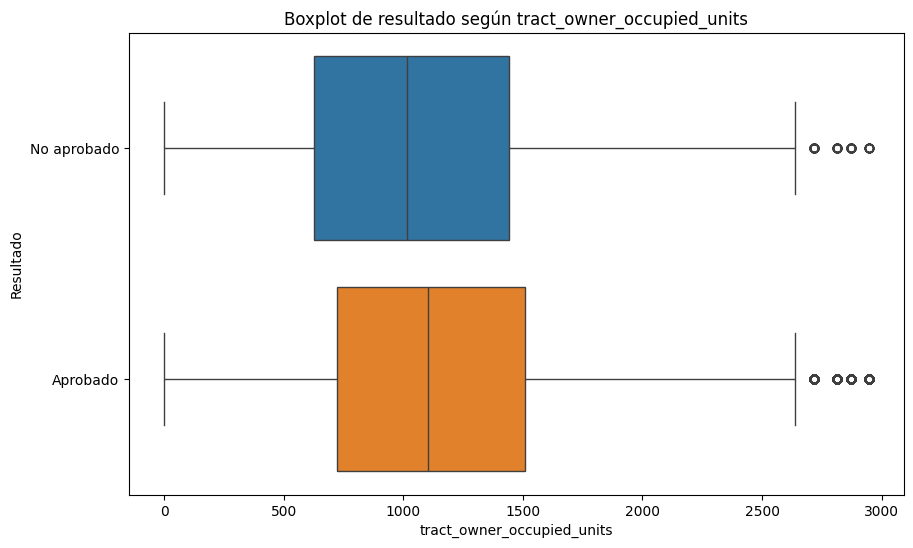

In [17]:
plot_numerical('tract_owner_occupied_units')

Se puede ver como la mediana de los aprobados es mayor a la de los desaprobados, de todos modos, siguen compartiendo la tendencia de tener resultados similares para ambas categorías.



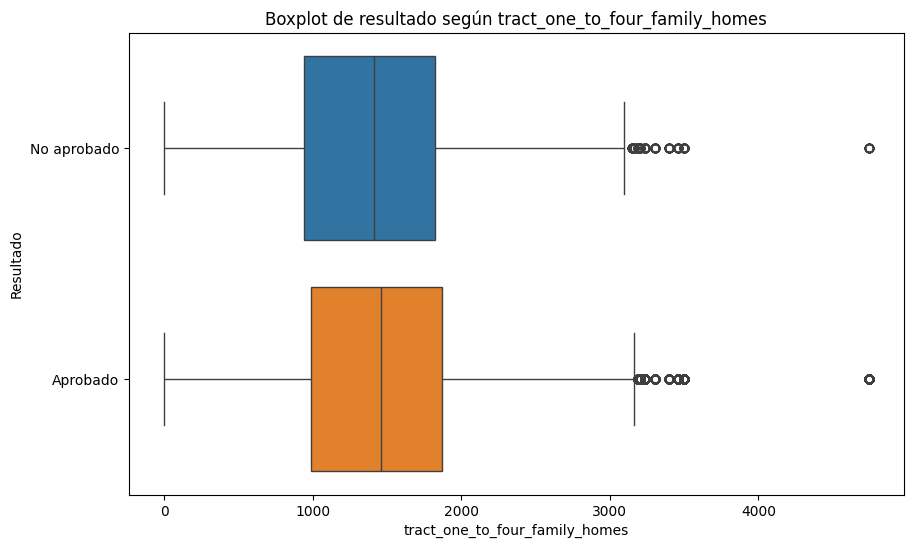

In [18]:
plot_numerical('tract_one_to_four_family_homes')

De la misma forma, a pesar que la mediana de los aprobados sea un poco superior, tenemos una distribución similar para ambos resultados.



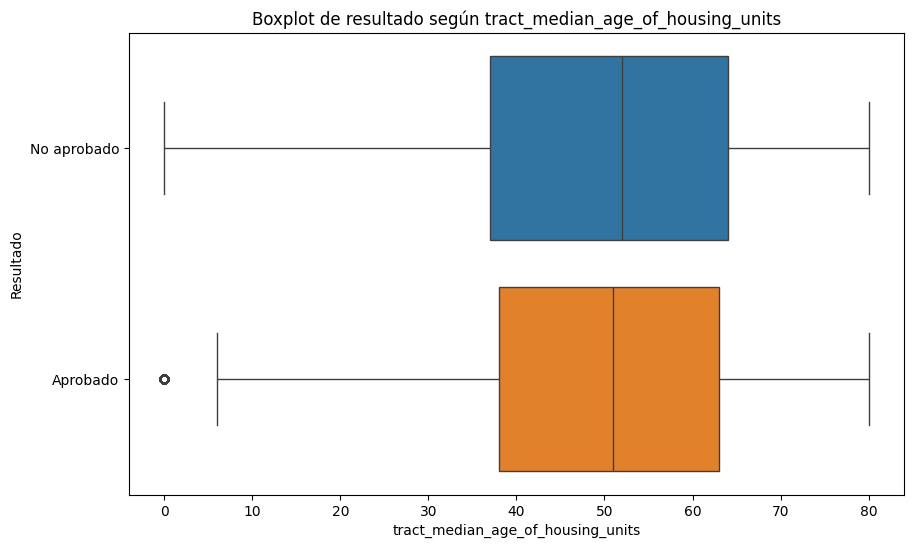

In [19]:
plot_numerical('tract_median_age_of_housing_units')

En última instancia, encontramos lo mismo para esta variable, todo esto nos puede indicar que las variables relacionadas al sector no son necesarias para los modelos, o bien que hay otras variables sobre el sector que se deberían tener en cuenta para tener un mayor rango de información.